   # Laborator 8: MLP in Pytorch

**Partea 1** Sa se creeze si antreneze un model de tip MLP, folosind setul de date MNIST. Arhitecura modelului - numarul de neuroni in straturile ascunse - va fi data ca o lista de intregi, de exemplu:
`architecture=[100, 40, 20]` reprezinta o retea MLP cu 3 straturi ascunse, cu cate 100, 40, respectiv 20 de neuroni in straturile ascunse. Se va transmite, de asemenea functia de activare folosita pentru straturile ascunse. Se vor tipari (pe masura ce se antreneaza) si reprezenta grafic (la final de instruire): loss pe setul de antrenare, loss si acuratete pe setul de testare pentru fiecare de instruire.

**Partea a doua**. Automatizati procesul de cautare pentru arhitectura retelei si learnign rate:
1. Definiti o lista de learnign rates candidate, e.g. lrs = [1e-2, 1e-3, 1e-4]
1. Definiti o lista de arhitecturi candidate, e.g. architectures=[[100, 40, 20], [200, 40]]
1. Iterati peste toate combinatiile de learnign rate si arhitecturi; antrenati cate un model pe fiecare combinatie in parte, testati pe setul de testare. Retineti acea combinatie (lr, architecture) care duce la acuratete maxima pe setul de testare. 
1. Optional, puteti adauga alti hiperparametri pentru modele: valoarea coeficientului de momentum si weight decay pentru SGD, numarul de epoci.

Note: 
1. Pentru adaugarea de module la structura retelei se poate folosi clasa [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). 
1. Functiile de activare se pot alege din cele [definite in Pytorch].(https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)

Termen de predare: 3 mai 2023, ora 23:00

Se vor folosi type annotations pentru variabile, parametrii tuturor funcțiilor, tipuri de retur. Tema se noteaza doar in prezenta studentului; rezolvarile sunt individuale.

Se acordă doua puncte din oficiu. Fișierul va fi denumit tema5_ia_nume_prenume.ipynb. Verificați înainte de trimitere faptul ca execuția celulelor de sus în jos funcționează corespunzător.

Setting up the inputs

In [371]:
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from typing import Tuple, List

Setting up the device

In [372]:
device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

Setting up the MNIST dataset

In [373]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

Define dataloader, grouping in batches

In [374]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0
)

In [375]:
assert len(train_loader) == (len(train_dataset) + batch_size - 1) // batch_size
assert len(test_loader) == (len(test_dataset) + batch_size - 1) // batch_size

for x, y in train_loader:
    assert abs(x.min()) < 1e-5 and abs(1-x.max()) <= 1e-5
    print('Primul batch: ', x.shape, y.shape)
    assert x.shape[0] == y.shape[0]
    break

Primul batch:  torch.Size([64, 1, 28, 28]) torch.Size([64])


Define ActivationModule class for nn.Sequential

In [376]:
class ActivationModule(nn.Module):
    def __init__(self, activation):
        super(ActivationModule, self).__init__()
        self.activation = activation
    def forward(self, x):
        return self.activation(x)

Neural Network class

In [377]:
class MLP(nn.Module):
    def __init__(self, input_size: int = 784, hidden_size: List[int] = None, classes: int = 10, activations = None):
        super(MLP, self).__init__()
        if hidden_size is None:
            hidden_size = [100, 40, 20]
        if activations is None:
            activations = [nn.functional.relu, nn.functional.sigmoid, nn.functional.tanh]
        assert len(hidden_size) == len(activations)

        #add first layer
        layers = [nn.Linear(input_size, hidden_size[0])]

        #add hidden layers
        for index in range(len(hidden_size) - 1):
            layers.append(ActivationModule(activations[index]))
            layers.append(nn.Linear(hidden_size[index], hidden_size[index + 1]))

        #add output layer
        layers.append(ActivationModule(activations[-1]))
        layers.append(nn.Linear(hidden_size[-1], classes))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        x = self.model(x)
        return x

Define test function for nn

In [378]:
@torch.no_grad()
def test(
        model: nn.Module,
        criterion: nn.CrossEntropyLoss,
        loader: torch.utils.data.DataLoader,
        device: torch.device
) -> Tuple[float, float]:
    model.eval()
    accuracy, test_loss = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        test_loss += criterion(y_hat, y).item() * x.shape[0]
        _, predicted = torch.max(y_hat, axis=1)
        accuracy += (predicted == y).sum().item()
    accuracy /= len(loader.dataset)
    test_loss /= len(loader.dataset)
    return accuracy, test_loss

Define training loop

In [379]:
def train(model: nn.Module,
          epochs: int,
          criterion: nn.CrossEntropyLoss,
          train_loader: torch.utils.data.DataLoader,
          test_loader: torch.utils.data.DataLoader,
          device: torch.device) -> None:
    train_losses = []
    test_accuracies = []
    test_losses = []
    test_accuracy_untrained, test_loss_untrained = test(model, criterion, test_loader, device)
    print(f'On untrained model, test set: acc={test_accuracy_untrained*100:.2f}, loss={test_loss_untrained:.4f}')

    for epoch in range(1, epochs + 1):
        model.train()
        running_train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            running_train_loss += loss.item() * x.shape[0]

            model.zero_grad()
            loss.backward()
            optimizer.step()
        train_losses.append(running_train_loss / len(train_loader.dataset))
        test_accuracy, test_loss = test(model, criterion, test_loader, device)
        print(f'Epoch {epoch}/{epochs}, train set: loss={train_losses[-1]:.4f}')
        print(f'Epoch {epoch}/{epochs}, test set: acc={test_accuracy*100:.2f}%, loss={test_loss:.4f}')
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
    x_epochs = list(range(1, epochs+1))
    plt.title('Loss curves')
    plt.plot(x_epochs, train_losses, 'red', label='Train loss')
    plt.plot(x_epochs, test_losses, 'green', label='Test loss')
    plt.legend(loc='best')
    plt.show()

    plt.title('Test accuracy')
    plt.plot(x_epochs, test_accuracies)
    plt.show()

Define the model

In [380]:
model = MLP(hidden_size=[100, 40, 30, 20], activations=[nn.functional.relu, nn.functional.tanh, nn.functional.relu, nn.functional.sigmoid])

model.to(device)

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ActivationModule()
    (2): Linear(in_features=100, out_features=40, bias=True)
    (3): ActivationModule()
    (4): Linear(in_features=40, out_features=30, bias=True)
    (5): ActivationModule()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): ActivationModule()
    (8): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [381]:
from torchsummary import summary
summary(model)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       78,500
|    └─ActivationModule: 2-2             --
|    └─Linear: 2-3                       4,040
|    └─ActivationModule: 2-4             --
|    └─Linear: 2-5                       1,230
|    └─ActivationModule: 2-6             --
|    └─Linear: 2-7                       620
|    └─ActivationModule: 2-8             --
|    └─Linear: 2-9                       210
Total params: 84,600
Trainable params: 84,600
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       78,500
|    └─ActivationModule: 2-2             --
|    └─Linear: 2-3                       4,040
|    └─ActivationModule: 2-4             --
|    └─Linear: 2-5                       1,230
|    └─ActivationModule: 2-6             --
|    └─Linear: 2-7                       620
|    └─ActivationModule: 2-8             --
|    └─Linear: 2-9                       210
Total params: 84,600
Trainable params: 84,600
Non-trainable params: 0

Define hyper parameters and optimizer

In [382]:
epochs = 30
lr = 1e-2
momentum = 0.85
weight_decay = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

On untrained model, test set: acc=9.80, loss=2.3335
Epoch 1/30, train set: loss=2.2322
Epoch 1/30, test set: acc=28.37%, loss=1.8644
Epoch 2/30, train set: loss=1.2523
Epoch 2/30, test set: acc=84.16%, loss=0.6829
Epoch 3/30, train set: loss=0.4917
Epoch 3/30, test set: acc=91.03%, loss=0.3676
Epoch 4/30, train set: loss=0.2890
Epoch 4/30, test set: acc=93.92%, loss=0.2456
Epoch 5/30, train set: loss=0.2232
Epoch 5/30, test set: acc=94.65%, loss=0.2104
Epoch 6/30, train set: loss=0.1862
Epoch 6/30, test set: acc=95.13%, loss=0.1883
Epoch 7/30, train set: loss=0.1613
Epoch 7/30, test set: acc=95.87%, loss=0.1641
Epoch 8/30, train set: loss=0.1467
Epoch 8/30, test set: acc=95.64%, loss=0.1638
Epoch 9/30, train set: loss=0.1340
Epoch 9/30, test set: acc=95.99%, loss=0.1526
Epoch 10/30, train set: loss=0.1229
Epoch 10/30, test set: acc=96.20%, loss=0.1507
Epoch 11/30, train set: loss=0.1158
Epoch 11/30, test set: acc=96.26%, loss=0.1472
Epoch 12/30, train set: loss=0.1076
Epoch 12/30, test

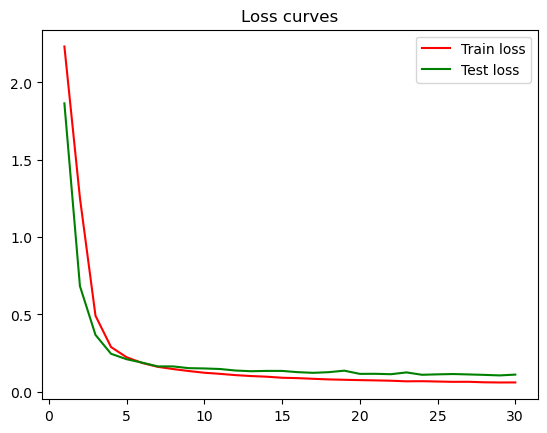

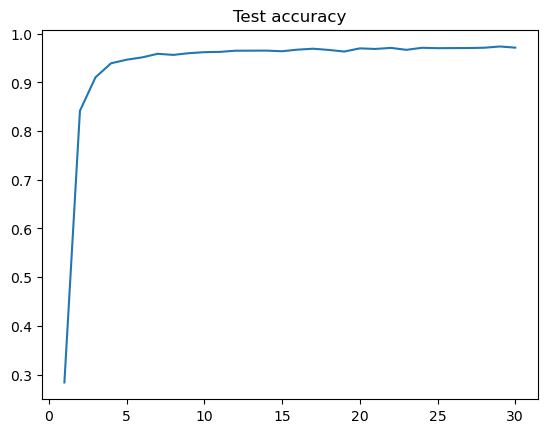

In [383]:
train(model, epochs, criterion, train_loader, test_loader, device)